We use the setup from Predjer et al 2010.

* $N$ workers in the platform through the period of the study, with different levels of arrival and departure
* We have $K$ time periods 
* We assume memoryless arrivals and departures, with $\lambda_k$ the arrivals at time $k$ and $\mu_k$ the departures at time $k$.
* Worker $i$ arrives (birth) at time $b_i$ and departs at time $d_i$ (both unobserved)
* Each worker has a capture history $C_i = [0 \ldots 0 1 \ldots 0 1 0 \ldots 0 0 0]$, where $H$ is a vector with $K$ binary values, and with $c_{ik}=1$ indicating that the worker $i$  appeared in the survey during the the $k$-th time period. 
* We use $u_i$ to denote the number of times that we captured the worker. 
* We use $f_i$ to denote the first time period that we see worker $i$, 
* We use $l_i$ to denote the last time period that we see worker $i$.
* We use $a_i$ for the propensity of worker $i$ to participate in the task. We assume that $a_i$ is distributed according to a Beta distribution $P(a_i) \propto B(\alpha, \beta)$.

The likelihood function for a worker that participated at least once is:

### $L_i = \sum_{s=1}^{f_i} \sum_{q=l_i}^K \lambda_s \cdot \left( \prod_{v=s}^{q-1} \left( 1 - \mu_v \right) \right) \cdot \mu_q \cdot R_i(s,q) $

where we use $s$ sum index to denote the (unobserved) arrival time, and $q$ to denote the (unobserved) departure time, with the limitation that $s$ is before $f_i$ and $q$ is after $l_i$. (So the part above gives the likelihood of arrival at $s$ and departure times.) Given the $s$ and $q$, we then define:

### $R_i(s,q) = \int_0^1 \left( \prod_{k=s}^{q} a_i^{c_{ik}} \cdot (1-a_i)^{1-c_{ik}} \right) dP(a_i) $

with the $R_i$ capturing the likelihood of observing the capture history of the worker with a propensity $a_i$, integrated over all possible propensity values.

By expanding $P(a_i) \propto B(\alpha, \beta)$, and using the same process as when deriving the Beta-Binomial distribution, we can simplify the above expression as: 

### $R_i(s,q) = \prod_{k=s}^{q} \frac{B(c_{ik} + \alpha, 1-c_{ik} + \beta)}{B(\alpha, \beta)}$

So, if the worker $i$ has been captured $u_i$ times, between their arrival at time $s$ and their departure at $q$, we have:

### $R_i(s,q) = B(1 + \alpha, \beta)^{u_i} \cdot B(\alpha, 1 + \beta)^{q-s-u_i} \cdot B(\alpha, \beta)^{-(q-s)}$

and by using the properties of the Beta function $B(x+1,y) = B(x, y) \cdot \dfrac{x}{x+y}$ and $B(x,y+1) = B(x, y) \cdot \dfrac{y}{x+y}$, we simplify further:

### $R_i(s,q) = \alpha^{u_i} \cdot \beta^{q-s-u_i} / (\alpha+\beta)^{q-s}$

### $R_i(s,q) = \left(\frac{\alpha}{\beta}\right)^{u_i} \cdot \left( \frac{\beta}{\alpha+\beta} \right)^{q-s}$

So, the overall likelihood function for a worker with $u_i$ captures between times $f_i$ and $l_i$ becomes:

### $L_i = \left(\frac{\alpha}{\beta}\right)^{u_i} \sum_{s=1}^{f_i} \sum_{q=l_i}^K \lambda_s \cdot  \left( \prod_{v=s}^{q-1} \left(1 - \mu_v\right) \right) \cdot \mu_q \cdot  \left( \frac{\beta}{\alpha+\beta} \right)^{q-s} $

and for the never observed workers:

### $L_0 = \sum_{s=1}^{K} \sum_{q=s}^K \lambda_s \cdot \left( \prod_{v=s}^{q-1} \left( 1 - \mu_v \right) \right) \cdot \mu_q \cdot  \left( \frac{\beta}{\alpha+\beta} \right)^{q-s} $


In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
# import tensorflow.contrib.eager as tfe
# tfe.enable_eager_execution()

In [3]:
df = pd.read_csv("mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')
I = len(workers)

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['hit_answered_date'])
df['period'] = (df['date'] - minDate).dt.days // window_length + 1
K = df['period'].max()

data = df.pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

data.head(10)

,count,max,min
index,,,
0,1,29,29
1,1,32,32
2,5,31,6
3,8,35,20
4,2,34,32
5,1,19,19
6,1,17,17
7,1,33,33
8,1,4,4


In [4]:
print("K (periods):", K)
print("I (workers):", I)

K (periods): 35
I (workers): 46145


In [5]:
# A vector with I dimensions, describing the first time we saw each of the I observed workers
f = tf.placeholder(tf.float64, shape=[I], name="first_time_seen")  
# f = tf.constant(data['min'], name="first_time_seen")
f

<tf.Tensor 'first_time_seen:0' shape=(46145,) dtype=float64>

In [6]:
# A vector with I dimensions, describing the last time we saw each of the I observed workers
l = tf.placeholder(tf.float64, shape=[I], name="last_time_seen")  
# l = tf.constant(data['max'], name="last_time_seen")
l

<tf.Tensor 'last_time_seen:0' shape=(46145,) dtype=float64>

In [7]:
# A vector with I dimensions, describing the number of time we saw each of the I observed workers
u = tf.placeholder(tf.float64, shape=[I], name="count") 
# u = tf.constant(data['count'], name="count", dtype=tf.float64)
u

<tf.Tensor 'count:0' shape=(46145,) dtype=float64>

In [8]:
# Propensity distribution parametes (propensity ~ Beta(a,b))
# TODO: We need to put constraints to avoid these becoming negative. 
# Does not seem to matter in our case but better safe than sorry.
a = tf.get_variable("pronensity_alpha", shape=(), dtype=tf.float64, initializer=tf.constant_initializer(0.01)  )
b = tf.get_variable("pronensity_beta",  shape=(), dtype=tf.float64, initializer=tf.constant_initializer(20) )

In [9]:
# Arrival and departure rates
# In our likelihood lambda_s and mu_q are treated as probabilities and cannot be negative
# To ensure non-negativity, and put the values between 0..1, we will start with two unconstrained
# parameters, which we will then convert into a 0..1 variable using a tanh. 
# Then, we can use the standard unconstrained optimization on lh and mh
lh = tf.get_variable("arrivals_latent",   [K], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer())
mh = tf.get_variable("departures_latent", [K], dtype=tf.float64, initializer=tf.contrib.layers.xavier_initializer())

# Ensures the values lambda and mu are positive and between 0 and 1
lmd = tf.sigmoid(lh, name='arrivals')
mu  = tf.sigmoid(mh, name='departures')

### $L_i = \left(\frac{\alpha}{\beta}\right)^{u_i} \sum_{s=1}^{f_i} \sum_{q=l_i}^K \lambda_s \cdot  \left( \prod_{v=s}^{q-1} \left(1 - \mu_v\right) \right) \cdot \mu_q \cdot  \left( \frac{\beta}{\alpha+\beta} \right)^{q-s} $

and for the never observed workers:

### $L_0 = \sum_{s=1}^{K} \sum_{q=s}^K \lambda_s \cdot \left( \prod_{v=s}^{q-1} \left( 1 - \mu_v \right) \right) \cdot \mu_q \cdot  \left( \frac{\beta}{\alpha+\beta} \right)^{q-s} $


In [10]:
# To allow for the sums of variable length s .. f_i and l_i...K, we will use binary masks
# This allows the products to be defined over a constant set of dimensions (ie. 1..K instead of 1..fi)

In [11]:
# Create masks using the values from f so that for each worker we add the lamda_s until the first appearance
s_mask = tf.sequence_mask(f+1, K)
s_mask = tf.cast(s_mask, tf.float64)

# broadcast lmd to be I x K matrix 
# replicate I times and then reshape to an I x K matrix
lambda_s = tf.reshape(tf.tile(lmd, [I]), [I,K]) 
lambda_s = tf.multiply(lambda_s, s_mask) # the mask eliminates the lambda_s that we do not care about
lambda_s

<tf.Tensor 'Mul:0' shape=(46145, 35) dtype=float64>

In [12]:
# Create masks using the values from l so that for each worker we add the mu_q from the first appearance until the end
q_mask = ~tf.sequence_mask(l-1, K)
q_mask = tf.cast(q_mask, tf.float64)

mu_q = tf.reshape(tf.tile(mu, [I]), [I,K]) 
mu_q = tf.multiply( mu_q  , q_mask ) 
mu_q

<tf.Tensor 'Mul_1:0' shape=(46145, 35) dtype=float64>

In [13]:
# And create a mask to calculate the product of 1-mu_v
v = np.zeros([K,K,K])
for s in np.arange(K):
    for q in np.arange(s,K):
        c1 = np.zeros(s)  
        c2 = np.ones(q-s)
        c3 = np.zeros(K-q) 
        v[s,q]= np.concatenate((c1, c2, c3))
v_mask = tf.constant(v)

mu_v = tf.pow(mu, v_mask)
mu_v = tf.reduce_prod(mu_v, axis=2)
mu_v

<tf.Tensor 'Prod:0' shape=(35, 35) dtype=float64>

In [14]:
# We are creating a matrix with the q-s exponents in order
# to raise b/a+b to q-s. Our operation will results in an K x K matrix
# for all possible s,q values
sq = np.zeros([K,K])
for s in range(K):
    for q in range(s,K):
        sq[s,q] = q-s
p_sq = tf.pow(tf.div(b, a+b), tf.constant(sq))
p_sq

<tf.Tensor 'Pow_1:0' shape=(35, 35) dtype=float64>

In [15]:
# We use einsum to calculate the product of lambda_s, mu_v, mu_q, p_sq
# This creates a tensor with shape I x s=1..K x q=1..K
products = tf.einsum('is,iq,sq,sq->isq', lambda_s, mu_q, mu_v, p_sq)
# and then we take the sum of the products over s (axis 1) and q (axis 2) 
# to compute Likelihood_i which is a vector with dimension I
Li = tf.pow(tf.div(a,b), u) * tf.reduce_sum(products, axis=[1,2])
Li

<tf.Tensor 'mul:0' shape=(46145,) dtype=float64>

In [16]:
# Once we have the individual likelihoods, we take the sum of their logs
objective = tf.reduce_sum(-tf.log(Li))
objective

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
train_step = tf.train.AdamOptimizer(learning_rate=0.05).minimize(objective)

In [18]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss = []

In [19]:
t = tqdm(range(500))

feed_data = {
    f: np.array(data['min']),  
    l: np.array(data['max']), 
    u: np.array(data['count'])
}

for epoch in t: 
    _, obj_value, a_est, b_est, lmd_est, mu_est = sess.run([train_step, objective, a, b, lmd, mu], feed_dict=feed_data)
    
    avg_lambda = np.mean(lmd_est)
    avg_mu = np.mean(mu_est) 
    std_lambda = np.std(lmd_est)
    std_mu = np.std(mu_est)
    loss.append( {"Iteration": epoch, "Loss": obj_value, "a_est": a_est, "b_est": b_est } )
    template = "{obj:10.3f} / {alpha:6.3f} / {beta:6.3f} / {al:6.3f} / {am:6.3f} / {sl:6.3f} / {sm:6.3f}"
    status = template.format(
                    obj = obj_value, 
                    alpha = a_est, 
                    beta = b_est, 
                    al = avg_lambda, 
                    am =avg_mu, 
                    sl = std_lambda,
                    sm = std_mu)
    t.set_description(status)


 40155.283 /  1.512 /  2.677 /  0.994 /  0.996 /  0.001 /  0.001: 100%|██████████| 500/500 [00:41<00:00, 12.13it/s]


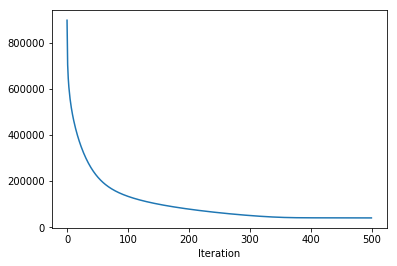

In [20]:
pd.DataFrame(loss).set_index('Iteration').Loss.plot()

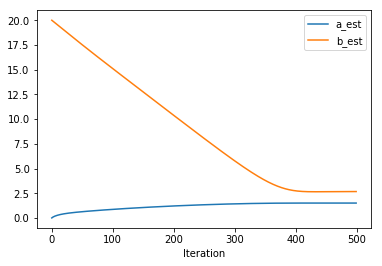

In [21]:
pd.DataFrame(loss).set_index('Iteration')[ ['a_est','b_est'] ].plot()